In [1]:
import os
import sys

sys.path.append("../")

from glob import glob
from argparse import ArgumentParser, Namespace

import numpy as np
import pandas as pd
import torch
import wandb
from omegaconf import DictConfig, OmegaConf
from rich.progress import track
from tqdm import tqdm
from torch.utils.data import DataLoader

from src.dataset import preprocess, TrainAlphaDataset
from src.portfolio import PortfolioFormer
from src.trainer import MultiAlphaTrainer
from src.model.nn_model import AlphaSelfAttention
from src.model.loss import ICLoss, InverseICLoss
from src.utils.utils import dict2mat, seed_all, rolling

In [2]:
parser = ArgumentParser()
parser.add_argument("--symlink_path", type=str, default="data/symlink")
parser.add_argument("--folder_path", type=str)
parser.add_argument("--gpuid", type=int, default=0)
parser.add_argument("--quick_expr", action="store_true")
parser.add_argument("--train_scale", type=int, default=561)
parser.add_argument("--look_back_window", type=int, default=60)
parser.add_argument("--direction", type=str, default="pos")
parser.add_argument("--label_type", type=str, default="cumret")
parser.add_argument("--future_window", type=int, default=5)
parser.add_argument("--wandb_track", action="store_true")
parser.add_argument("--n_epochs", type=int, default=50)
parser.add_argument("--batch_size", type=int, default=1)
parser.add_argument("--loss_multiplier", type=float, default=1.0)
parser.add_argument("--threshold", type=float, default=0.1)

args = parser.parse_args(
    "--symlink_path ../data/symlink "
    "--quick_expr "
    "--train_scale 561 "
    "--look_back_window 60 "
    "--direction pos "
    "--label_type cumret "
    "--future_window 5 "
    "--n_epochs 100 "
    "--batch_size 1 "
    "--threshold 0.05 ".split()
)
print(args.__dict__)

{'symlink_path': '../data/symlink', 'folder_path': None, 'gpuid': 0, 'quick_expr': True, 'train_scale': 561, 'look_back_window': 60, 'direction': 'pos', 'label_type': 'cumret', 'future_window': 5, 'wandb_track': False, 'n_epochs': 100, 'batch_size': 1, 'loss_multiplier': 1.0, 'threshold': 0.05}


In [3]:
stock_conf = OmegaConf.load("../config/selected_stocks.yaml")
seed_all(2025)

if args.symlink_path:    
    folder_path = os.readlink(args.symlink_path)
else:
    folder_path = args.folder_path

device = f"cuda:{args.gpuid}" if torch.cuda.is_available() else "cpu"
stock = {}

for _, path in track(
    enumerate(glob(f"{folder_path}/*.csv")), description="Loading files..."
):
    curr_df = pd.read_csv(path)
    stock_name = os.path.basename(path).split(".")[0]

    if len(curr_df) >= 4000:
        stock[stock_name] = curr_df

if args.quick_expr:
    subset = {k: stock[k] for k in list(stock_conf.for_expr)}
else:
    subset = stock

stock_amount = len(subset)
shortest_sequence = min([len(v) for v in subset.values()])
preprocessed = preprocess(
    subset,
    args.label_type,
    args.future_window,
    args.direction
)
first_train, test = dict2mat(preprocessed, args.train_scale, shortest_sequence)
first_train = np.transpose(first_train, (1, 0, 2))  # (days, stocks, features)
test = np.transpose(test, (1, 0, 2))  # (days, stocks, label)

tr_window_feat, tr_window_label = rolling(
    first_train, args.look_back_window
)  # (n_day - lbw, n_stocks, n_feat * lbw), (n_day - lbw, n_stocks, n_feat * lbw)
ts_window_feat, ts_window_label = rolling(test, args.look_back_window)
first_train_dataset = TrainAlphaDataset(tr_window_feat, tr_window_label)
first_train_loader = DataLoader(
    first_train_dataset,
    batch_size=args.batch_size,
    shuffle=True
)

print("Data preparation complete")

Output()

Output()

Data preparation complete


In [4]:
model = AlphaSelfAttention(
    input_dim=tr_window_feat.shape[-1],
    embed_dim=128,
    num_heads=1,
    dropout=0.1,
    kdim=None,
    vdim=None,
    final_output_dim=10,
    device=device,
    dtype=torch.float32,
    value_weight_type="vanilla",
).to(device)

model_path = f"vanilla_attn_epoch_{args.n_epochs}_bs{args.batch_size}_tr_{args.train_scale}_lbw_{args.look_back_window}_fw_{args.future_window}{args.direction}{args.label_type}.pt"
label_loss = ICLoss(ic_type="spearman")
pool_loss = InverseICLoss(ic_type="spearman")
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
trainer = MultiAlphaTrainer(
    model,
    "attention",
    label_loss,
    pool_loss,
    device,
    model_path
)

train = False
if train:
    trainer.multi_asset_train(args.n_epochs, first_train_loader, optimizer)
else:
    model_type = "attention"
    model.load_state_dict(
        torch.load(
            f"../model/{model_path}",
            map_location=device,
        )
    )

    y_preds = []

    for i, (test_features, test_label) in tqdm(enumerate(zip(ts_window_feat, ts_window_label))):
        if i % args.future_window == 0:
            if model_type == "attention":
                test_features, test_label = (
                    torch.tensor(test_features, dtype=torch.float32).unsqueeze(0),
                    torch.tensor(test_label, dtype=torch.float32).unsqueeze(0),
                )
            else:
                test_features, test_label = (
                    torch.tensor(test_features, dtype=torch.float32),
                    torch.tensor(test_label, dtype=torch.float32),
                )
            with torch.no_grad():
                model.train(False)
                y_pred = model(test_features)

            y_preds.append(y_pred[0].cpu().numpy())

3667it [00:00, 18207.11it/s]


In [11]:
pf = PortfolioFormer(
    train_scale=args.train_scale,
    look_back_window=args.look_back_window,
    shortest_seq=shortest_sequence,
    future_window=args.future_window,
    num_stocks=stock_amount
)
lrf, srf, brf, prf = pf.form_portfolio(y_preds, subset, 2, 2)

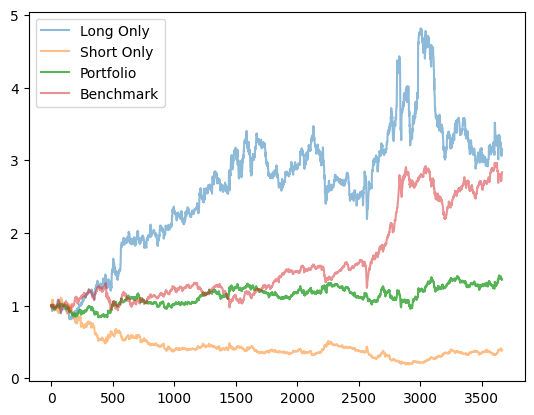

In [12]:
import matplotlib.pyplot as plt
plt.style.use("default")


plt.plot(np.cumprod(1 + lrf), label="Long Only", alpha=0.5)
plt.plot(np.cumprod(1 + srf), label="Short Only", alpha=0.5)
plt.plot(np.cumprod(1 + prf), label="Portfolio", alpha=0.8)
plt.plot(np.cumprod(1 + brf), label="Benchmark", alpha=0.5)
plt.legend()
plt.show()

In [13]:
class Metrics:
    def __init__(
        self, ret_sequence: list[np.ndarray]
    ) -> None:
        self.rets = ret_sequence

    def annual_ret(self, ret):
        return np.mean(ret) * 252

    def sharpe(self, ret):
        return (np.mean(ret) / np.std(ret)) * np.sqrt(252)

    def mdd(self, ret):
        cumsumret = ret.cumsum()
        running_max = np.maximum.accumulate(cumsumret)
        dd = cumsumret - running_max
        mdd = -1 * np.min(dd)

        return mdd

    def calmar(self, ret):
        return self.annual_ret(ret) / self.mdd(ret)

    def read(self, strats: list[str]):
        for i, ret in enumerate(self.rets):
            dic = {
                "annual return": self.annual_ret(ret),
                "annual sharpe": self.sharpe(ret),
                "mdd": self.mdd(ret),
                "calmar": self.calmar(ret)
            }
            print(f"{strats[i]} performance: {dic}")

In [14]:
met = Metrics([lrf, srf, prf, brf])
met.read(["Long Only", "Short Only", "Portfolio", "Benchmark"])

Long Only performance: {'annual return': 0.10035336453621486, 'annual sharpe': 0.48258050013437376, 'mdd': 0.4830016174154972, 'calmar': 0.20777024531138766}
Short Only performance: {'annual return': -0.04059829113990108, 'annual sharpe': -0.18165975312936888, 'mdd': 1.4767556288057238, 'calmar': -0.027491543182898565}
Portfolio performance: {'annual return': 0.02987753669815689, 'annual sharpe': 0.2252197374368453, 'mdd': 0.2856358142501907, 'calmar': 0.10460010687590779}
Benchmark performance: {'annual return': 0.08016441497066336, 'annual sharpe': 0.6143729963586019, 'mdd': 0.3188801857408039, 'calmar': 0.25139352821320665}
